| Version | Date       | Developer | Remark             |
|---------|------------|-----------|--------------------|
| 1.0     | Feb-1-2025 | Johnson | Initial version: build models with sklearn & MLlib    |

**Context**

The insurance.csv dataset contains 1338 observations (rows) and 7 features (columns). The dataset contains 4 numerical features (age, bmi, children and expenses) and 3 nominal features (sex, smoker and region) that were converted into factors with numerical value designated for each level.

**Data source**: [Kaggle](https://www.kaggle.com/datasets/noordeen/insurance-premium-prediction?select=insurance.csv)

# 1. Exploratory Data Analysis

In [0]:
%run ./Common_Function

In [0]:
data = '/Workspace/Users/hejiekun@hotmail.com/insurance.csv'
df = pd.read_csv(data)
df_sp = spark.createDataFrame(df)
display(df_sp.limit(10))

age,sex,bmi,children,smoker,region,expenses
19,female,27.9,0,yes,southwest,16884.92
18,male,33.8,1,no,southeast,1725.55
28,male,33.0,3,no,southeast,4449.46
33,male,22.7,0,no,northwest,21984.47
32,male,28.9,0,no,northwest,3866.86
31,female,25.7,0,no,southeast,3756.62
46,female,33.4,1,no,southeast,8240.59
37,female,27.7,3,no,northwest,7281.51
37,male,29.8,2,no,northeast,6406.41
60,female,25.8,0,no,northwest,28923.14


In [0]:
num_rows = df_sp.count()  # Count the number of rows
num_cols = len(df_sp.columns)  # Count the number of columns
print(f'{num_rows} Records,{num_cols} Features.')

1338 Records,7 Features.


In [0]:
df_sp.printSchema()

root
 |-- age: long (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: long (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- expenses: double (nullable = true)



In [0]:
df_pd = df_sp.toPandas() # Transfer to Pandas 

print(df.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64


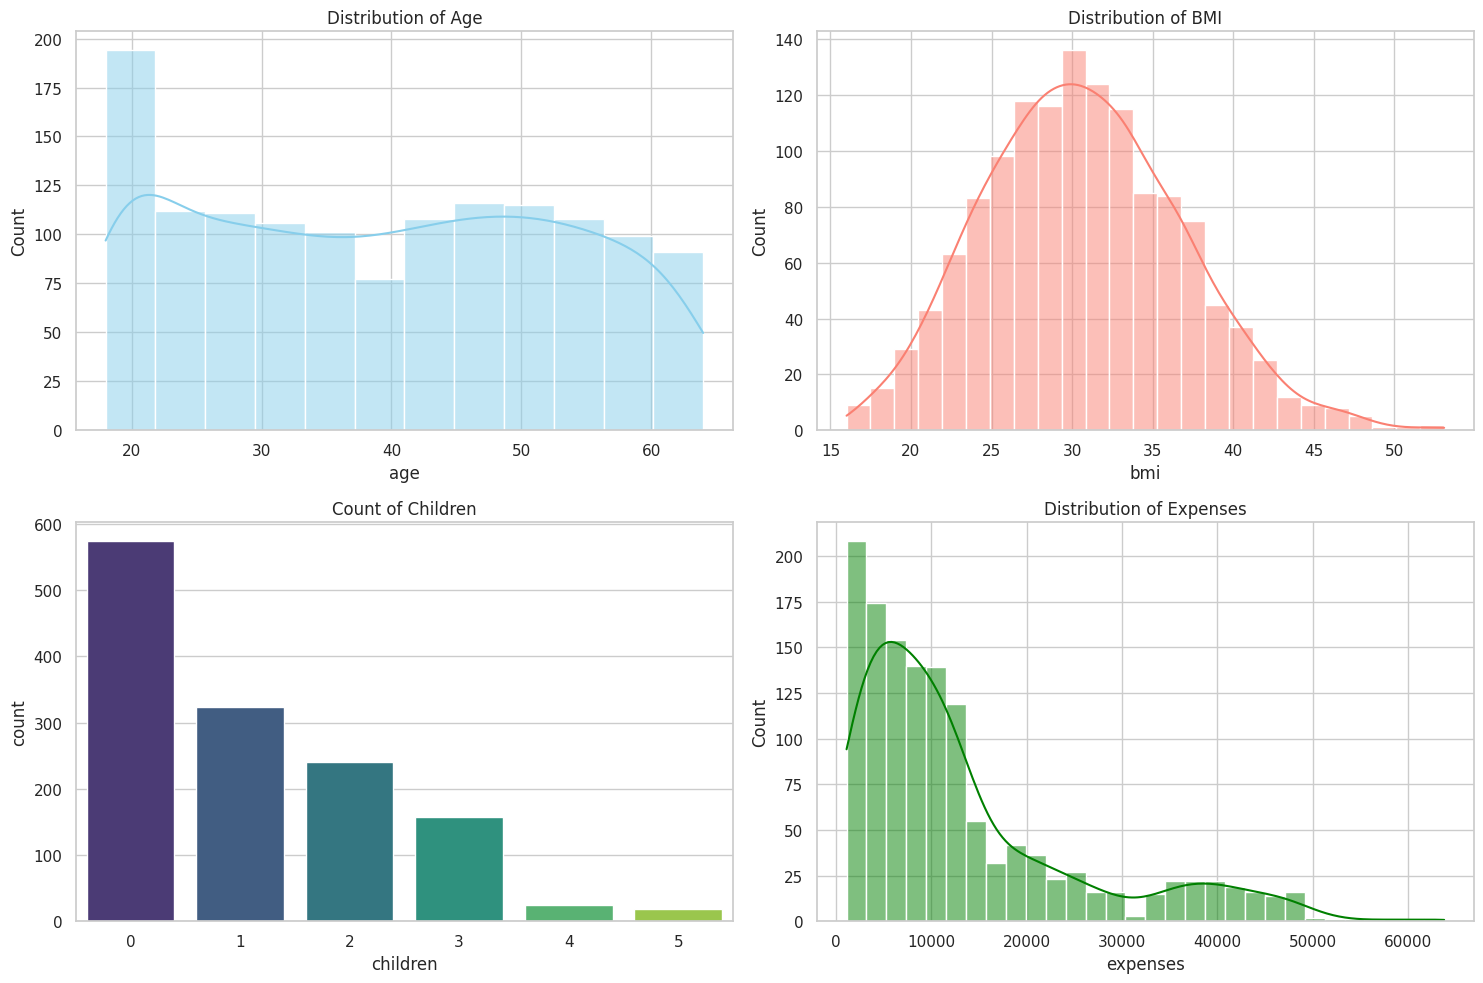

In [0]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribution of 'age'
sns.histplot(df_pd['age'], kde=True, ax=axes[0, 0], color="skyblue")
axes[0, 0].set_title('Distribution of Age')
# Distribution of 'bmi'
sns.histplot(df_pd['bmi'], kde=True, ax=axes[0, 1], color="salmon")
axes[0, 1].set_title('Distribution of BMI')
# Distribution of 'children'
sns.countplot(x='children', data=df_pd, palette="viridis", ax=axes[1, 0])
axes[1, 0].set_title('Count of Children')
# Distribution of 'expenses'
sns.histplot(df['expenses'], kde=True, ax=axes[1, 1], color="green")
axes[1, 1].set_title('Distribution of Expenses')

plt.tight_layout()
plt.show()

# Pairplot to see relationships and scatter patterns
# sns.pairplot(df, hue="smoker", palette="coolwarm")
# plt.show()

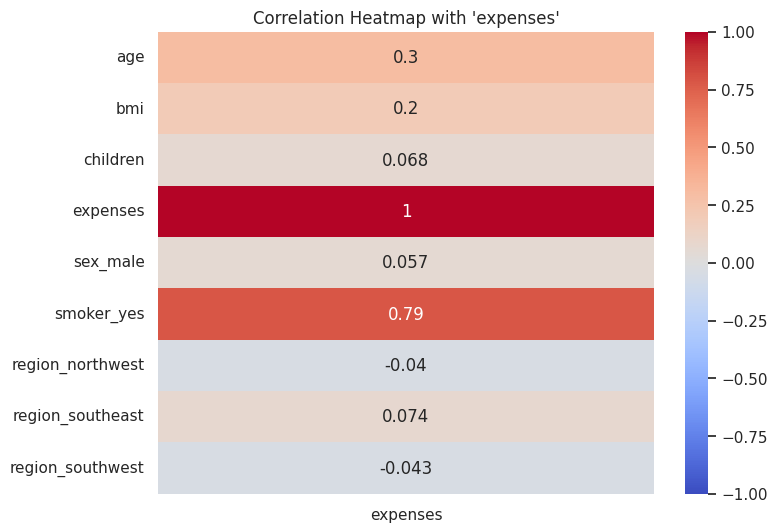

In [0]:
# Using pd.get_dummies to encoding the categorical variable
df_encoded = pd.get_dummies(df, drop_first=True)

# Calculate the correlation between encoded features
corr = df_encoded.corr()

# Focus on correlation with target 'expenses'
charges_corr = corr['expenses'].sort_values(ascending=False)

# Show correlation results with charges
print(charges_corr)

# Visualization of correlation in heatmap form
plt.figure(figsize=(8, 6))
sns.heatmap(corr[['expenses']], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap with 'expenses'")
plt.show()



In [0]:
# Check the missing values
print(df.isnull().sum())

# Impute missing values ​​(if any) for numeric columns with median
# df = df_encoded.fillna(df_encoded.median())

# 2. Data Engineering

In [0]:
pipeline_model = pipeline.fit(df_sp)  # Fit the pipeline
df_transformed = pipeline_model.transform(df_sp)  # Transform the data

# Show transformed data
display(df_transformed.select("sex", "sex_index", "smoker", "smoker_index", "region", "region_encoded", "bmi_normalized", "age_normalized").limit(5))

sex,sex_index,smoker,smoker_index,region,region_encoded,bmi_normalized,age_normalized
female,1.0,yes,1.0,southwest,"Map(vectorType -> sparse, length -> 3, indices -> List(2), values -> List(1.0))","Map(vectorType -> dense, length -> 1, values -> List(0.320754716981132))","Map(vectorType -> dense, length -> 1, values -> List(0.021739130434782608))"
male,0.0,no,0.0,southeast,"Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> dense, length -> 1, values -> List(0.4797843665768193))","Map(vectorType -> dense, length -> 1, values -> List(0.0))"
male,0.0,no,0.0,southeast,"Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> dense, length -> 1, values -> List(0.4582210242587601))","Map(vectorType -> dense, length -> 1, values -> List(0.21739130434782608))"
male,0.0,no,0.0,northwest,"Map(vectorType -> sparse, length -> 3, indices -> List(1), values -> List(1.0))","Map(vectorType -> dense, length -> 1, values -> List(0.1805929919137466))","Map(vectorType -> dense, length -> 1, values -> List(0.32608695652173914))"
male,0.0,no,0.0,northwest,"Map(vectorType -> sparse, length -> 3, indices -> List(1), values -> List(1.0))","Map(vectorType -> dense, length -> 1, values -> List(0.34770889487870615))","Map(vectorType -> dense, length -> 1, values -> List(0.30434782608695654))"


In [0]:
# Call the function with df_transformed as input
df_final = vectorize_features(df_transformed)
display(df_final.limit(5))

label,features
16884.92,"Map(vectorType -> dense, length -> 8, values -> List(1.0, 1.0, 0.0, 0.0, 1.0, 0.320754716981132, 0.021739130434782608, 0.0))"
1725.55,"Map(vectorType -> sparse, length -> 8, indices -> List(2, 5, 7), values -> List(1.0, 0.4797843665768193, 1.0))"
4449.46,"Map(vectorType -> sparse, length -> 8, indices -> List(2, 5, 6, 7), values -> List(1.0, 0.4582210242587601, 0.21739130434782608, 3.0))"
21984.47,"Map(vectorType -> sparse, length -> 8, indices -> List(3, 5, 6), values -> List(1.0, 0.1805929919137466, 0.32608695652173914))"
3866.86,"Map(vectorType -> sparse, length -> 8, indices -> List(3, 5, 6), values -> List(1.0, 0.34770889487870615, 0.30434782608695654))"


In [0]:
# Make sure we do pd.get_dummies() for the entire dataset
df_encoded = pd.get_dummies(df, drop_first=True)

# Separate features and targets
X = df_encoded.drop('expenses', axis=1)  # Fitur
y = df_encoded['expenses']  # Target (charges)

# Check some data to make sure there are no remaining strings
print(X.head())

In [0]:
from sklearn.preprocessing import StandardScaler

# Features standarization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [0]:
# Check the data type of each column
print(X.dtypes)

In [0]:
# Split data into 80% training and 20% testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Check the dimensions of training and testing data
print(X_train.shape, X_test.shape)

In [0]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Standardization of training and testing data
X_train_scaled = scaler.fit_transform(X_train)  # Fit pada data training
X_test_scaled = scaler.transform(X_test)  # Transform data testing

# 3. Model Training and Evaluation Metrics

In [0]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
predictions_rf = rf.predict(X_test_scaled)

from sklearn.metrics import mean_squared_error, r2_score

mse_linear = mean_squared_error(y_test, predictions_rf)
r2_linear = r2_score(y_test, predictions_rf)

print(f"Linear Regression - MSE: {mse_linear}, R2: {r2_linear}")

# 4.Explain The Model 

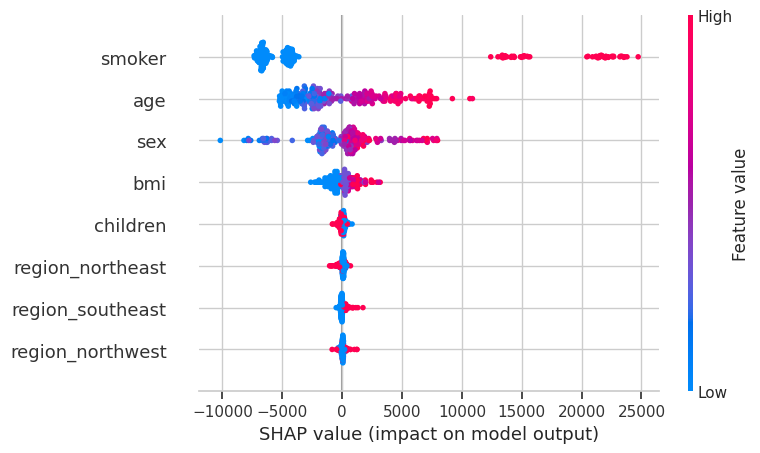

In [0]:
import shap

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
predictions_rf = rf.predict(X_test_scaled)

explainer = shap.Explainer(rf, X_train_scaled)
shap_values = explainer(X_test_scaled, check_additivity=False)



feature_names = ['age', 'sex', 'bmi', 'children', 'smoker', 'region_southeast','region_northwest','region_northeast']
shap.summary_plot(shap_values, feature_names=feature_names)
